# Atomic Electronic Density Fitting


This file will showcase how to use information-theoritic fitting for atomic electronic density fitting.

Denote $\rho(r)$ to be the slater electronic density for an element. Here, we're choosing Beryllium ("be").
Since the atomic number of Beryllium is 4, then $\int_{0}^{\infty} \rho(r) 4 \pi r^2 dr \approx 4.$

This example will fit $\rho(r)$ to a linear combination of 5 S-type and 3 P-type, normalized Gaussian functions, 
denoted as $\tilde{\rho}(r)$.  In other words,


$$\tilde{\rho}(r) = \sum_{i=1}^5 c_i \bigg(\frac{\alpha_i}{\pi}\bigg)^{\frac{3}{2}} e^{-\alpha_i r^2} + \sum_{i=1}^3 d_i \bigg(\frac{3\pi^{\frac{3}{2}}}{2 \beta_i^{\frac{5}{2}}}\bigg)r^2 e^{-\beta_i r^2},$$

such that $\sum_{i=1}^5 c_i + \sum_{i=1}^3 d_i = 4$.


The fitting algorithm will try to find the best $\tilde{\rho}(r)$ that minimizes the Kullback-Leibler function $K(X, Y)$ between the true density 
$\rho(r)$ and the fitted density $\tilde{\rho}(r)$:

$$K(\rho(r), \tilde{\rho}(r)) = \int_{0}^{\infty} \rho(r) \log\bigg(\frac{\rho(r)}{\tilde{\rho}(r)} \bigg) 4\pi r^2 dr.$$

## 1. Specify a radial grid.

The first step is to specify a one-dimensional (radial) grid.

The ClenshawCurtis grid is chosen here and is recommended for radial grids since it centers the points where the electron density is thought to be high.
However, just to make sure let's add additional points [25, 50, 75]. 

In [1]:
import numpy as np
from bfit.grid import ClenshawRadialGrid

atomic_numb = 4
grid = ClenshawRadialGrid(atomic_numb, num_core_pts=400, num_diffuse_pts=500, 
                          extra_pts=[25, 50, 75])

## 2. Get Slater density.

The next step is to get the slater electronic density.

Additionally, let's integrate to make sure the integral is indeed close to 19 and let's plot it.

('The integral of potassium is: ', 3.9999910287814453924)


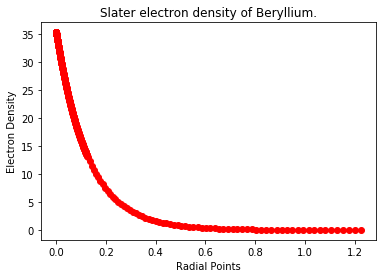

In [2]:
from bfit.density import AtomicDensity

# Grab information about potassium.
be = AtomicDensity("be")

# Get the total electronic density.
density = be.atomic_density(grid.points, "total")

print("The integral of potassium is: ", grid.integrate(density))

# Plot only the first 500 points.
import matplotlib.pyplot as plt
plt.plot(grid.points[:500], density[:500], "ro-")
plt.xlabel("Radial Points")
plt.ylabel("Electron Density")
plt.title("Slater electron density of Beryllium.")
plt.show()

All atoms from "H" to "Xenon" can be obtained from the "AtomicDensity" class.
Additionally, the core and valence density can also be provided.

##  3. Specify the Gaussian model.

The next step is to defined the normalized Gaussian density $\tilde{\rho}(r)$ with 5 S-type and 3 P-type functions. 

In [3]:
from fitting.model import AtomicGaussianDensity

model = AtomicGaussianDensity(grid.points, num_s=5, num_p=3, normalize=True)


## 4. Specify the Kullback-Leibler Self-Consistent Field Method.

All the pieces are in place to provide to the "KLDivergenceSCF" class.

In [4]:
from fitting.fit import KLDivergenceSCF

fit = KLDivergenceSCF(grid, density, model)

Before doing so, we need to have a initial guess for the coefficients and exponents of the Gaussian density $\tilde{\rho}(r)$.  

Here are some tips for initial guesses.
- The initial guess for coefficients do not matter, since it becomes a concave function over a concave domain.
- For the exponents, it is recommended to use a well-spread out (even-tempered set) and they should all be different.

Let's try out a random guess and see how it compares.

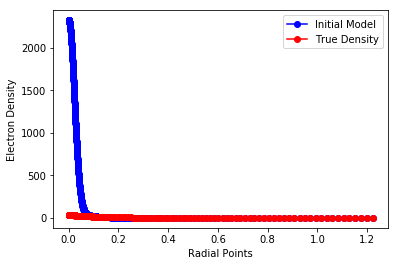

In [5]:
c_0 = np.array([0.2, 0.5, 0.2, 0.3, 0.4, 0.6, 0.7, 0.9])
e_0 = np.array([0.001, 0.1, 10., 100., 1000., 0.01, 0.1, 1.])

model0 = model.evaluate(c_0, e_0)

numb_pts = 500
plt.plot(grid.points[:numb_pts], model0[:numb_pts], "bo-", label="Initial Model")
plt.plot(grid.points[:numb_pts], density[:numb_pts], "ro-", label="True Density")
plt.xlabel("Radial Points")
plt.ylabel("Electron Density")
plt.legend()
plt.show()

As you can see the initial guess does not seem as great. Let's try optimizing and plotting the following error measures:
The integrated value, the $L_1$ and $L_\infty$ norm:

$$L_1(\rho, \tilde{\rho}) = \int_{0}^{\infty} |\rho(r) - \tilde{\rho}(r)|4 \pi r^2 dr \qquad L_\infty(\rho, \tilde{\rho}) = \max_{r\in[0, \infty)} |\rho(r) - \tilde{\rho}(r)|,$$

and the Kullback-Leibler $K(\tilde{\rho}, \rho).$

('Was it successful? ', True)
('Is it normalized? ', 3.9999910287814453)


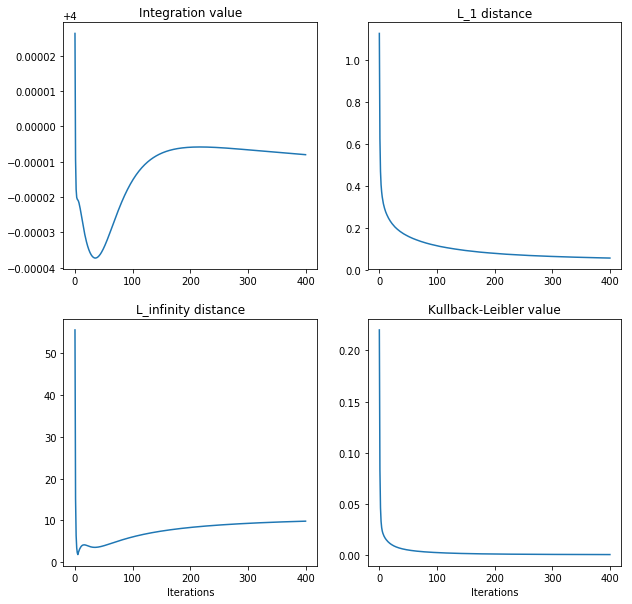

In [6]:
results = fit.run(c_0, e_0, maxiter=1000)


c_final, e_final = results["x"]
print("Was it successful? ", results["success"])
print("Is it normalized? ", np.sum(c_final))
model0 = model.evaluate(c_final, e_final)

# Plot the error measures.
fig, axs = plt.subplots(2, 2, figsize=(10,10))
axs[0, 0].plot(results["performance"][:, 0])
axs[0, 0].set_title("Integration value")
axs[0, 1].plot(results["performance"][:, 1])
axs[0, 1].set_title("L_1 distance")
axs[1, 0].plot(results["performance"][:, 2])
axs[1, 0].set_title("L_infinity distance")
axs[1, 1].plot(results["performance"][:, 3])
axs[1, 1].set_title("Kullback-Leibler value")

for ax in fig.get_axes()[2:]:
    ax.set(xlabel='Iterations')
plt.show()

Finally, let's plot it to the true density and compare.

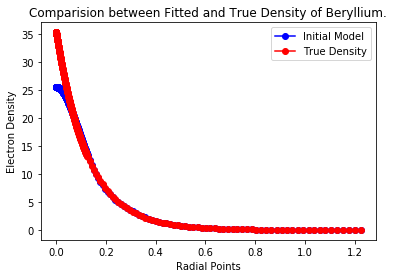

In [7]:
numb_pts = 500
plt.title("Comparision between Fitted and True Density of Beryllium.")
plt.plot(grid.points[:numb_pts], model0[:numb_pts], "bo-", label="Initial Model")
plt.plot(grid.points[:numb_pts], density[:numb_pts], "ro-", label="True Density")
plt.xlabel("Radial Points")
plt.ylabel("Electron Density")
plt.legend()
plt.show()

And that's it. The name of the game is to now find either better initial guesses or find the right amount of basis functions or increase the number of iterations and threshold parameters.